<a href="https://colab.research.google.com/github/sashkoangelov/Sample-difficulty-estimation-through-action-scores-for-various-NLP-tasks/blob/main/RoBERTa_tweeteval_sentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
%%capture

!pip install transformers
!pip install tensorflow
!pip install contractions

In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import nltk
nltk.download('stopwords')
import re
import string
from nltk.corpus import stopwords
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.tensorboard import SummaryWriter
import logging
import contractions
from tqdm.notebook import tqdm
logging.basicConfig(level=logging.ERROR)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Ensuring GPU usage

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# Data loading

In [4]:
train = pd.read_parquet('/content/drive/MyDrive/Thesis/Datasets/tweet_eval/train-00000-of-00001.parquet')
validation = pd.read_parquet('/content/drive/MyDrive/Thesis/Datasets/tweet_eval/validation-00000-of-00001.parquet')
test = pd.read_parquet('/content/drive/MyDrive/Thesis/Datasets/tweet_eval/test-00000-of-00001.parquet')

In [5]:
train.head()

,text,label
0,"""QT @user In the original draft of the 7th boo...",2
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,2


## Class distribution

<ipython-input-6-44ab78fdbf97>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=train, palette='dark')


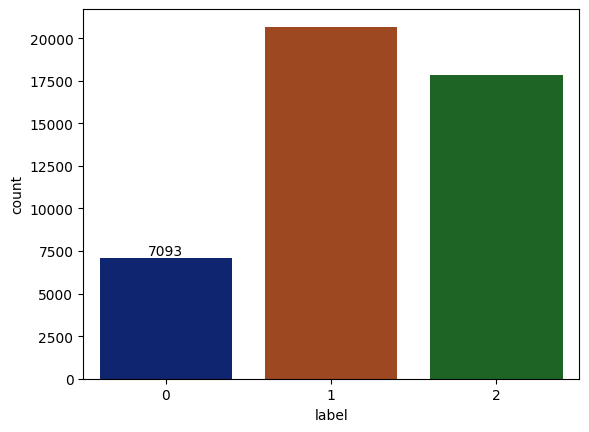

In [6]:
ax = sns.countplot(x='label', data=train, palette='dark')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

## Cleaning

###Converting from object datatype to strings and category. Needed for regex operations

In [7]:
train["label"] = train["label"].astype("category")
train["text"] = train["text"].apply(str)

validation["label"] = validation["label"].astype("category")
validation["text"] = validation["text"].apply(str)

test["label"] = test["label"].astype("category")
test["text"] = test["text"].apply(str)

###Data cleaning

In [8]:
def cleaning(tweet):

    # Removing all the @ mentions from the tweets
    tweet = re.sub(r"@[A-Za-z0-9]+","", tweet)

    # Removing the links from the tweets
    tweet = re.sub(r"https?://[A-Za-z0-9./]+","", tweet)

    # Removing unnecessary characters like emojis from the tweets
    tweet = re.sub(r"[^ A-Za-z0-9.!?']","", tweet)

    # Removing any extra whitespaces
    tweet = re.sub(r" +"," ", tweet)

    # Removing punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Removing numbers
    tweet = re.sub(r'\d+', '', tweet)

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tweet = ' '.join(word for word in tweet.split() if word not in stop_words)

    return tweet

In [9]:
train['clean_text'] = [cleaning(tweet) for tweet in train['text']]
validation['clean_text'] = [cleaning(tweet) for tweet in validation['text']]
test['clean_text'] = [cleaning(tweet) for tweet in test['text']]

###Removing duplicates

In [ ]:
print("Original number of samples:", len(train))

# Removing the duplicates
train = train.drop_duplicates(subset=['clean_text'], keep='first')

print("Number of samples after removing duplicates:", len(train))

###Removing very short samples

In [11]:
print("Original number of samples:", len(train))

# Define a lambda function to count words in a text
word_count = lambda text: len(text.split())

# Filtering out rows where the 'clean_text' column has texts shorter than 2 words
train = train[train['clean_text'].apply(word_count) >= 2]

print("Number of samples after filtering short texts:", len(train))


Original number of samples: 45462
Number of samples after filtering short texts: 45461


In [12]:
train['clean_text'] = train['clean_text'].apply(lambda x: contractions.fix(x))

In [13]:
train.head()

,text,label,clean_text
0,"""QT @user In the original draft of the 7th boo...",2,QT In original draft th book Remus Lupin survi...
1,"""Ben Smith / Smith (concussion) remains out of...",1,Ben Smith Smith concussion remains lineup Thur...
2,Sorry bout the stream last night I crashed out...,1,Sorry bout stream last night I crashed tonight...
3,Chase Headley's RBI double in the 8th inning o...,1,Chase Headleys RBI double th inning David Pric...
4,@user Alciato: Bee will invest 150 million in ...,2,Alciato Bee invest million January another Sum...


### Word clouds per class

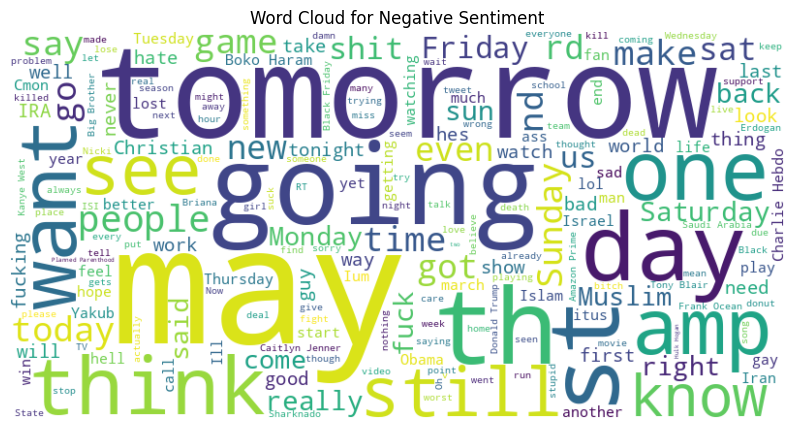

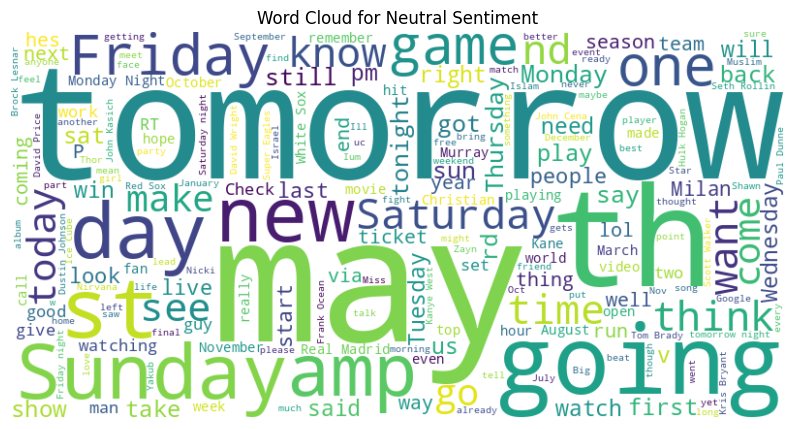

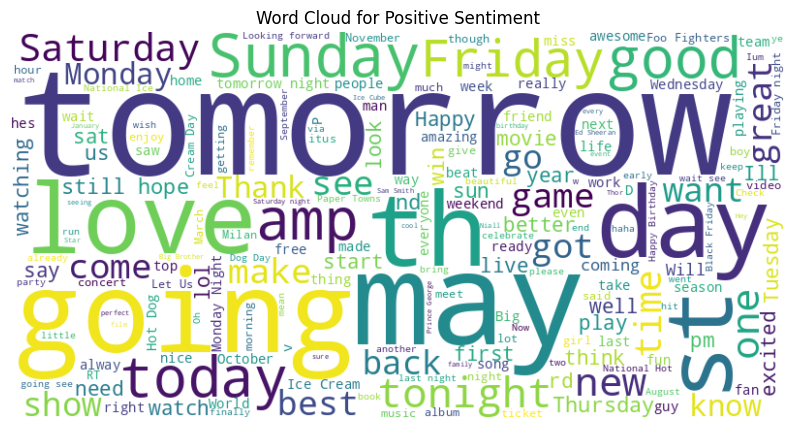

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_clouds(texts):
    # Create a word cloud for each sentiment class
    for label, texts in texts.items():
        # Filter out missing values and convert to strings
        texts = [str(text) for text in texts if pd.notna(text)]

        # Join all texts for the sentiment class into a single string
        text = ' '.join(texts)

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Plot word cloud
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for {label} Sentiment')
        plt.axis('off')
        plt.show()


# Preprocess data and organize into sentiment classes
def preprocess_data(df):
    # Mapping numeric labels to sentiment categories
    label_to_sentiment = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

    # Initialize the dictionary with sentiment categories
    sentiment_texts = {'Negative': [], 'Neutral': [], 'Positive': []}

    for index, row in df.iterrows():
        # Map the numeric label to its sentiment category
        sentiment_category = label_to_sentiment.get(row['label'], 'Unknown')

        # Append the text to the appropriate list based on its sentiment category
        text = row['clean_text']
        if sentiment_category != 'Unknown':  # Only proceed if the label is recognized
            sentiment_texts[sentiment_category].append(text)

    return sentiment_texts

# Example usage
import pandas as pd

# Preprocess the data
sentiment_texts = preprocess_data(train)

# Generate word clouds
generate_word_clouds(sentiment_texts)

In [15]:
train.head()

,text,label,clean_text
0,"""QT @user In the original draft of the 7th boo...",2,QT In original draft th book Remus Lupin survi...
1,"""Ben Smith / Smith (concussion) remains out of...",1,Ben Smith Smith concussion remains lineup Thur...
2,Sorry bout the stream last night I crashed out...,1,Sorry bout stream last night I crashed tonight...
3,Chase Headley's RBI double in the 8th inning o...,1,Chase Headleys RBI double th inning David Pric...
4,@user Alciato: Bee will invest 150 million in ...,2,Alciato Bee invest million January another Sum...


#Fine-tuning

In [25]:
# Define hyperparameters
MAX_LEN = 256
BATCH_SIZE = 32
LR = 1e-05
EPOCHS = 5


In [26]:
# Define dataset class
class CustomDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = str(self.tweets[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [27]:
# Instantiate the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define evaluation function
def evaluate_fn(model, val_loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return all_labels, all_preds

# Create DataLoader
train_dataset = CustomDataset(
    tweets=train['clean_text'].values,
    labels=train['label'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
def train_fn_1(model, train_loader, optimizer, loss_function, device):
    model.train()
    losses = []
    total_loss = 0.0

    progress_bar = tqdm(train_loader, desc='Training')

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)

        individual_losses = loss_function(outputs.logits, labels)

        loss = individual_losses.mean()  # Calculate the mean loss for backpropagation.
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)  # Accumulate the total loss.

        # Optionally, update the progress bar description with the current loss
        progress_bar.set_description(f"Epoch {epoch + 1}/{EPOCHS} - Loss: {loss.item():.4f}")

        for i in range(len(input_ids)):
            sample_loss = {
                'tweet_text': batch['tweet_text'][i],
                'loss': individual_losses[i].item()  # Storing individual loss for each sample.
            }
            losses.append(sample_loss)

    # Calculate the average training loss for the epoch.
    train_loss = total_loss / len(train_loader.dataset)

    return train_loss, losses

## Training loop

In [38]:
# Dictionary to track the losses
all_losses = {}

optimizer = AdamW(model.parameters(), lr=LR)
loss_function = torch.nn.CrossEntropyLoss(reduction='none')

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_loss, epoch_losses = train_fn_1(model, train_loader, optimizer, loss_function, device)

    # Update the all_losses dictionary
    for loss_entry in epoch_losses:
        tweet_text = loss_entry['tweet_text']
        loss_value = loss_entry['loss']

        if tweet_text not in all_losses:
            all_losses[tweet_text] = [loss_value]  # Start a new list for this sample
        else:
            all_losses[tweet_text].append(loss_value)  # Append the new loss to the existing list for this sample

    print(f'Training Loss: {train_loss}')


Epoch 1/5


Training:   0%|          | 0/1421 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
for i, (key, value) in enumerate(all_losses.items()):
    print(f'{key}: {value}')
    if i == 9:
        break

May Feng Shui Be With These Five Star WarsThemed Household Items Star Wars day little strange beca: [1.0222679376602173, 6.437682628631592]
Canada responded Monday GOP presidential contender Scott Walkers controversial comments building: [1.0761475563049316, 0.20199911296367645]
I canut wait til Saturday Iull pregame show tomorrowuci love college gameday Ium glad Gameday LSU GEAUX TIGERS: [1.019385576248169, 2.234797716140747]
I hosting Open Lobby Saturday th Tomorrow PM PM UK Time Gamertag iL Ash Li Be guys itus going awesome: [1.0434203147888184, 5.049652099609375]
Whatever thoughts feelings Watchman giving come along July th chat things Mockingbird It Will lively discussion: [1.0983335971832275, 3.1910741329193115]
Jenna leave right make Sam Smith Glendale Arizona tomorrow I Am looking tickets right nowmy sister: [1.0595016479492188, 0.04117082431912422]
Hes going to pin Seth Rollins know John Cena must protected Sheamus walks titles Sunday: [1.0746874809265137, 0.1011330634355545]


In [23]:
highest_loss_sample = max(all_losses, key=lambda x: sum(all_losses[x])/len(all_losses[x]))
lowest_loss_sample = min(all_losses, key=lambda x: sum(all_losses[x])/len(all_losses[x]))

print("Sample with Highest Average Loss:")
print(f"Text: {highest_loss_sample}")
print(f"Average Loss: {sum(all_losses[highest_loss_sample])/len(all_losses[highest_loss_sample])}")

print("\nSample with Lowest Average Loss:")
print(f"Text: {lowest_loss_sample}")
print(f"Average Loss: {sum(all_losses[lowest_loss_sample])/len(all_losses[lowest_loss_sample])}")


Sample with Highest Average Loss:
Text: I forgot sad first episode th season Dexter depressing dexter darkpassenger
Average Loss: 9.093339681625366

Sample with Lowest Average Loss:
Text: CNET Update Amazon may cooking tablet Oh My God Welcome back I missed much
Average Loss: 0.011473797028884292


## Evaluate on test set

In [29]:
test_dataset = CustomDataset(
    tweets=test['clean_text'].values,
    labels=test['label'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

true_labels, pred_labels = evaluate_fn(model, test_loader, device)

# Calculate accuracy and other metrics
accuracy = accuracy_score(true_labels, pred_labels)
print(f'Accuracy: {accuracy}')

print(classification_report(true_labels, pred_labels))

Accuracy: 0.32334744382937153
              precision    recall  f1-score   support

           0       0.32      1.00      0.49      3972
           1       0.00      0.00      0.00      5937
           2       0.00      0.00      0.00      2375

    accuracy                           0.32     12284
   macro avg       0.11      0.33      0.16     12284
weighted avg       0.10      0.32      0.16     12284



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Save model, tokenizer and label encoder

In [ ]:
import os

# Specify the directory where you want to save the model
output_dir = '/content/drive/MyDrive/Thesis/Models'

# Save the model and tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Save label encoder using joblib or pickle
import joblib
joblib.dump(label_encoder, os.path.join(output_dir, 'label_encoder.pkl'))

# Inference

## Load model, tokenizer and label encoder

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
import joblib
import os

output_dir = '/content/drive/MyDrive/Thesis/Models'

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained(output_dir)

# Load the model
model = RobertaForSequenceClassification.from_pretrained(output_dir)

# Load the label encoder.
# Used to reverse map the numerical values to categorical predictions
label_encoder = joblib.load(os.path.join(output_dir, 'label_encoder.pkl'))

## Get sentiment function

In [ ]:
def get_sentiment(input_text, model, tokenizer, label_encoder, device):
    # Tokenize input text
    inputs = tokenizer(input_text, return_tensors='pt', max_length=256, truncation=True, padding='max_length')

    # Move input tensors to the same device as the model
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Pass input through model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Apply softmax to get probabilities
    probs = torch.softmax(outputs.logits, dim=1).squeeze()

    # Map probabilities to sentiment labels
    sentiment_probs = {label_encoder.classes_[i]: probs[i].item() for i in range(len(label_encoder.classes_))}

    return sentiment_probs

## Pie chart

In [ ]:
def pie_chart(sentiment_probs):
    # Define custom colors for each sentiment
    colors = ['gray', 'red', 'yellow', 'green']

    # Create a pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(sentiment_probs.values(), labels=None, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title("Sentiment Probabilities")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Add a legend with custom colors
    plt.legend(sentiment_probs.keys(), loc="best", bbox_to_anchor=(1, 0.5), title="Sentiments", fancybox=True, shadow=True)

    plt.tight_layout()
    plt.show()

## Inference

In [ ]:
import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_text = "Just finished my shit morning routine and heading to my awful work. The weather is neither too hot nor too cold, just perfect. Looking forward to a boring day ahead!"
sentiment_probs = get_sentiment(input_text, model.to(device), tokenizer, label_encoder, device)

print("Sentiment Probabilities:")
for sentiment, prob in sentiment_probs.items():
    print(f"{sentiment}: {prob:.4f}")

pie_chart(sentiment_probs)